In [1]:
!pip install seaborn
!pip install xgboost
!pip install shap

In [2]:
#Import

import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn import preprocessing

from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
import shap
import seaborn 


Import and inspect the data

In [3]:
train_dataset = pd.read_csv(r"data/train.csv", )
test_dataset = pd.read_csv(r"data/test.csv",index_col="trustii_id")

In [4]:
train_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,60,female,27.550,0,no,northeast,13217.09450
1,46,female,28.050,1,no,southeast,8233.09750
2,50,female,23.540,2,no,southeast,10107.22060
3,52,male,27.360,0,yes,northwest,24393.62240
4,54,male,32.775,0,no,northeast,10435.06525


Assert that there is no empty or nan values

In [5]:
percentage_of_empty_values= (train_dataset.isnull().sum().sum())/train_dataset.size *100
print(f"There are {percentage_of_empty_values} % of empty values in the dataframe")
percentage_of_rows_with_empty_values = (train_dataset.shape[0] - train_dataset.dropna().shape[0])/ train_dataset.shape[0] *100
print(f"There are {percentage_of_rows_with_empty_values} % of rows with empty values")

There are 0.0 % of empty values in the dataframe
There are 0.0 % of rows with empty values


Split the features and the target.

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       936 non-null    int64  
 1   sex       936 non-null    object 
 2   bmi       936 non-null    float64
 3   children  936 non-null    int64  
 4   smoker    936 non-null    object 
 5   region    936 non-null    object 
 6   charges   936 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 51.3+ KB


# Vizualisation of the target

<AxesSubplot:xlabel='charges'>

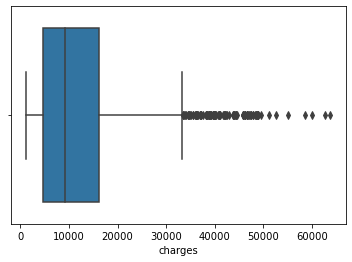

In [7]:
target = train_dataset["charges"]
sns.boxplot(x=target)

<AxesSubplot:xlabel='charges', ylabel='Count'>

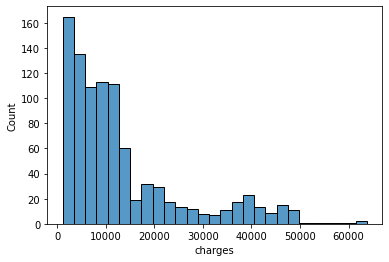

In [8]:
sns.histplot(x=target)

# Features Engineering

## Deal with categorical features.

In [9]:
train_dataset = pd.get_dummies(train_dataset)
test_dataset = pd.get_dummies(test_dataset)

In [10]:
features = train_dataset.columns.drop("charges")
train_dataset = train_dataset[features]

In [11]:
train_dataset.columns

Index(['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

Delete the binary features.

In [12]:
features = train_dataset.columns
columns_to_drop = ('sex_male','smoker_no') 

In [13]:
for feat in columns_to_drop:
    features= features.drop(feat)

In [14]:
features

Index(['age', 'bmi', 'children', 'sex_female', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')

In [15]:
train_dataset = train_dataset[features]*1.0
test_dataset= test_dataset[features]*1.0

In [16]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               936 non-null    float64
 1   bmi               936 non-null    float64
 2   children          936 non-null    float64
 3   sex_female        936 non-null    float64
 4   smoker_yes        936 non-null    float64
 5   region_northeast  936 non-null    float64
 6   region_northwest  936 non-null    float64
 7   region_southeast  936 non-null    float64
 8   region_southwest  936 non-null    float64
dtypes: float64(9)
memory usage: 65.9 KB


In [17]:
target= np.round(target, 2)
target

0      13217.09
1       8233.10
2      10107.22
3      24393.62
4      10435.07
         ...   
931    48675.52
932    10982.50
933     6753.04
934     5415.66
935     2585.27
Name: charges, Length: 936, dtype: float64

# Best Model Selection

In [18]:
metric = "r2"

features_best = ["smoker_yes","age","bmi","children"]
train_dataset = train_dataset[features_best]
test_dataset= test_dataset[features_best]

In [19]:
train_dataset.smoker_yes.count()

936

In [20]:
model = LinearRegression()

scores = cross_validate(model, train_dataset,target,cv=5,scoring=metric)
scores = pd.DataFrame(scores).mean()
scores

fit_time      0.001846
score_time    0.001291
test_score    0.748197
dtype: float64

In [21]:
# Try random Forest Classifier
model = RandomForestRegressor(n_estimators=150,max_depth=5)
params = {"n_estimators" :[50,100,150,200,250],"max_depth": [3,4,5,6]}
#scores = cross_validate(model, train_dataset,target,cv=5,scoring=metric)
clf = GridSearchCV(model, params,cv=5,refit=True,scoring="r2")        
clf.fit (train_dataset,target)         

print(clf.best_score_, clf.best_params_)

0.8631978215517966 {'max_depth': 4, 'n_estimators': 100}


In [22]:
model = SVR()
params = {"kernel":["linear", ],"C":[100000,10000,1000],"degree": [1,2,3]}
#scores = cross_validate(model, train_dataset,target,cv=5,scoring=metric)
clf = GridSearchCV(model, params,cv=3,refit=True)        
clf.fit (train_dataset,target)         

print(clf.best_score_, clf.best_params_)

0.6817419307667351 {'C': 10000, 'degree': 1, 'kernel': 'linear'}


In [ ]:
model = HistGradientBoostingRegressor()
params = {"max_iter" :[30,50,100,],"max_depth": [1,2,3,4,5],"max_leaf_nodes":[5,8,10]}
#scores = cross_validate(model, train_dataset,target,cv=5,scoring=metric)
clf = GridSearchCV(model, params,cv=5,refit=True,scoring="r2")        
clf.fit (train_dataset,target)         

print(clf.best_score_, clf.best_params_)

In [ ]:
model = GaussianProcessRegressor()
params = {}
#scores = cross_validate(model, train_dataset,target,cv=5,scoring=metric)
clf = GridSearchCV(model, params,cv=5,refit=True) #,scoring="r2")        
clf.fit (train_dataset,target)         

print(clf.best_score_, clf.best_params_)

Conclusion : HistGradientBoostingRegressor seems to give the best performances.

# Prediction 

In [ ]:
model = HistGradientBoostingRegressor(max_iter=50,max_depth=3,max_leaf_nodes=8)
model.fit(train_dataset,target)

In [ ]:
model.fit(train_dataset,target)

In [ ]:
y_test_pred=model.predict(test_dataset)

In [ ]:
len(y_test_pred)

# Explainability

In [ ]:
train_dataset.columns

In [ ]:
train = shap.sample(train_dataset,1000)


In [ ]:
explainer = shap.Explainer(model)

shap_values = explainer.shap_values(train)
shap.summary_plot(shap_values, train)

In [ ]:
#Here we can see the most important features for prediction
shap.summary_plot(shap_values, train, feature_names=train_dataset.columns, plot_type="bar")

# Push to the submission table

In [ ]:
original_validation_data = pd.read_csv(r"data/test.csv",index_col="trustii_id")
original_validation_data

In [ ]:
pred_dataframe = pd.DataFrame(y_test_pred,columns = ["charges"],index = [i for i in range(1,len(y_test_pred)+1)])

In [ ]:
original_validation_data["charges"]=pred_dataframe["charges"]

In [ ]:
original_validation_data

In [ ]:
original_validation_data.to_csv('my_submission.csv')